## Evaluating Hybrid model

In [4]:
# imports
import jax
import jax.numpy as jnp

# import jax_cfd.base.equations as eqtns
# import jax_cfd.base as cfd
# import jax_cfd.base.grids as grids

# import jax_cfd.base.advection as advection
# import jax_cfd.base.diffusion as diffusion
# from jax_cfd.base import finite_differences as fd

import numpy as np #?

import xarray
import seaborn
import pickle

import haiku as hk

import matplotlib.pyplot as plt

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

In [13]:
def makePath(which,dim1,dim2):
    return "./sims_50_seconds/{}_{:.0f}x{:.0f}.nc".format(which,dim1,dim2)


paths = {
    "dns_1024x256" : makePath("dns",1024,256),
    "dns_256x64" : makePath("dns",256,64),
    "dns_64x16" : makePath("dns",64,16),

    "LI_256x64" : makePath("LI",256,64),
    "LI_64x16" : makePath("LI",64,16)
}

In [14]:
paths

{'dns_1024x256': './sims_50_seconds/dns_1024x256.nc',
 'dns_256x64': './sims_50_seconds/dns_256x64.nc',
 'dns_64x16': './sims_50_seconds/dns_64x16.nc',
 'LI_256x64': './sims_50_seconds/LI_256x64.nc',
 'LI_64x16': './sims_50_seconds/LI_64x16.nc'}

In [15]:
models = paths.keys()

datasets = {}
for model in models:
    datasets[model] = xarray.open_dataset(paths[model], chunks={'time': '100MB'})

In [16]:
def sampling(data,factor):
    return data[:,0::factor,0::factor]

In [17]:
def myMse(data1,data2):    
    return np.mean((data1-data2)**2)

def myMape(data1,data2):
#     print(np.shape((data1-data2)))
#     print(np.shape(data1))
    return np.mean(np.abs((data1-data2)/data1))

In [18]:
def extractData(ds,factor=None):
    u = ds.u.values
    v = ds.v.values
    
    if factor is not None:
        u = sampling(u,factor)
        v = sampling(v,factor)
    
    out = []
    times,_,_ = np.shape(u)
    for time in range(times):
        
        out.append(np.stack([u[time,:,:],v[time,:,:]]))
    
    
    return out

In [19]:
def calculateErrors(reference,referenceFactor,otherSim,otherFactor):
    reference = extractData(reference,referenceFactor)
    otherSim = extractData(otherSim,otherFactor)
    
    (times,_,_,_) = np.shape(reference)
    errors = []
    for time in range(times):
#         print(time)
        errors.append(myMse(reference[time][:,:,:],otherSim[time][:,:,:]))
#         errors.append(myMape(reference[time][:,:,:],otherSim[time][:,:,:]))
    
    return errors

In [20]:
errors_LI_64x16 = calculateErrors(datasets["dns_1024x256"],16,datasets["LI_64x16"],None)
errors_LI_256x64 = calculateErrors(datasets["dns_1024x256"],4,datasets["LI_256x64"],None)

errors_DNS_256x64 = calculateErrors(datasets["dns_1024x256"],4,datasets["dns_256x64"],None)
errors_DNS_64x16 = calculateErrors(datasets["dns_1024x256"],16,datasets["dns_64x16"],None)

In [21]:
time = datasets["dns_1024x256"].time.values
time

array([10., 20., 30., 40., 50.])

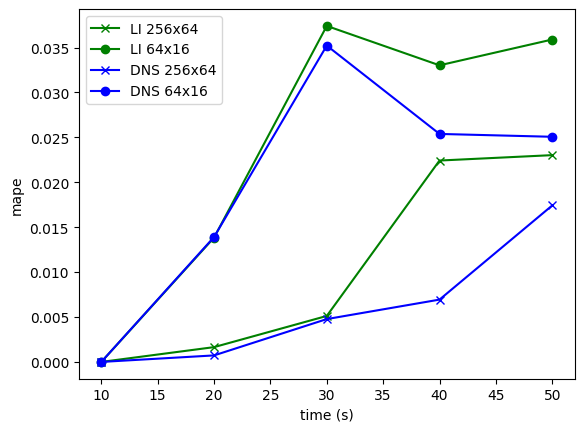

In [23]:
plt.plot(time,errors_LI_256x64,'-gx',label="LI 256x64")
plt.plot(time,errors_LI_64x16,'-go',label="LI 64x16")

plt.plot(time,errors_DNS_256x64,'-bx',label="DNS 256x64")
plt.plot(time,errors_DNS_64x16,'-bo',label="DNS 64x16")
plt.xlabel("time (s)")
plt.ylabel("mape")
plt.legend()
# plt.ylim([0,1])
# plt.xlim([40,50])

In [24]:
def findDivPoint(errors,tol):
    return len(errors)-sum(np.array(errors) > tol)

tol = 0.001
print(findDivPoint(errors_LI_64x16,tol))
print(findDivPoint(errors_LI_256x64,tol))

print(findDivPoint(errors_DNS_64x16,tol))
print(findDivPoint(errors_DNS_256x64,tol))

1
1
1
2


In [ ]:
np.shape(errors_DNS_256x64)